# El modelo 4.1  vs Xception con extracción de características

## Modelo 4.1

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [6]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")
content = os.listdir(original_dir)
BATCH_SIZE = 64
size_x = 256
size_y = 256

In [7]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

Found 9280 files belonging to 58 classes.
Found 1160 files belonging to 58 classes.
Found 1160 files belonging to 58 classes.


In [6]:
inputs = keras.Input(shape=(size_x, size_y, 3)) 
x = layers.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=16, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
residual = x
x = layers.MaxPooling2D(pool_size=2, padding = "same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, use_bias=False, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
residual = layers.Conv2D(64, 1, strides = 2)(residual)
x = layers.add([x, residual])
x = layers.Conv2D(filters=64, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
residual = x
x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False,  padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
residual = layers.Conv2D(128, 1, strides = 2)(residual)
x = layers.add([x, residual])
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
residual = x 
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 
residual = layers.Conv2D(256, 1)(residual)
x = layers.add([x, residual])
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(58, activation="softmax")(x)
model4_1_extended = keras.Model(inputs=inputs, outputs=outputs)

model4_1_extended.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 254, 254, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 254, 254, 16) 64          conv2d_11[0][0]                  
____________________________________________________________________________________________

In [7]:
model4_1_extended.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

history = model4_1_extended.fit(
 train_dataset,
 epochs=100,
 validation_data=validation_dataset)

Epoch 1/100
145/145 [==============================] - 83s 153ms/step - loss: 3.6992 - accuracy: 0.0792 - val_loss: 5.1696 - val_accuracy: 0.0302
Epoch 2/100
145/145 [==============================] - 48s 326ms/step - loss: 2.9981 - accuracy: 0.1784 - val_loss: 5.2302 - val_accuracy: 0.0267
Epoch 3/100
145/145 [==============================] - 21s 137ms/step - loss: 2.5984 - accuracy: 0.2553 - val_loss: 3.2319 - val_accuracy: 0.1483
Epoch 4/100
145/145 [==============================] - 20s 130ms/step - loss: 2.3072 - accuracy: 0.3148 - val_loss: 2.1029 - val_accuracy: 0.3819
Epoch 5/100
145/145 [==============================] - 24s 160ms/step - loss: 2.0804 - accuracy: 0.3673 - val_loss: 2.1954 - val_accuracy: 0.3431
Epoch 6/100
145/145 [==============================] - 24s 159ms/step - loss: 1.9180 - accuracy: 0.4126 - val_loss: 1.6018 - val_accuracy: 0.4897
Epoch 7/100
145/145 [==============================] - 25s 164ms/step - loss: 1.7740 - accuracy: 0.4537 - val_loss: 1.7894 -

In [8]:
model4_1_extended.save('model4_1_extended/model')
np.save('model4_1_extended/history.npy',history.history)

INFO:tensorflow:Assets written to: model4_1_extended/model\assets


F:\Programas\Anaconda\envs\TFGapp\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


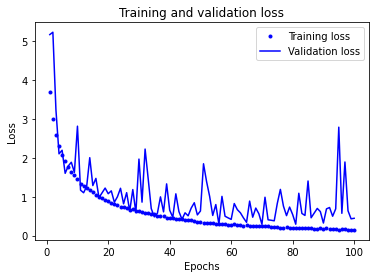

In [10]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b.", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

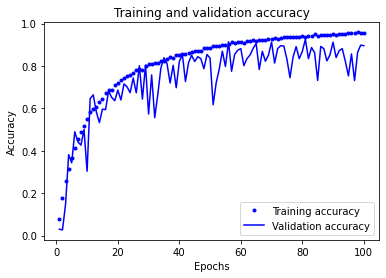

In [11]:
plt.clf()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, "b.", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
model = keras.models.load_model('model4_1_extended/model')
results= model.evaluate(test_dataset)
results

19/19 [==============================] - 3s 77ms/step - loss: 0.5244 - accuracy: 0.8836


[0.5244119167327881, 0.8836206793785095]

# Xception previamente entrenado con extracción de características

In [9]:
xception_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(size_x , size_y, 3))

In [10]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.xception.preprocess_input(images)
        features = xception_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [12]:
train_features.shape

(9280, 8, 8, 2048)

In [20]:
inputs = keras.Input(shape=(8, 8, 2048))
x = layers.Dense(256)(x)
x = layers.Dense(256)(x)
x = layers.Dense(256)(x)
x = layers.Flatten()(inputs) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(58, activation="softmax")(x)
model5 = keras.Model(inputs, outputs)

model5.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 58)                7602234   
Total params: 7,602,234
Trainable params: 7,602,234
Non-trainable params: 0
_________________________________________________________________


In [21]:
model5.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="model5/best_version",
 save_best_only=True,
 monitor="val_loss")
]

history = model5.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
    batch_size=BATCH_SIZE)

Epoch 1/30
145/145 [==============================] - 4s 17ms/step - loss: 5.5872 - accuracy: 0.6273 - val_loss: 3.0160 - val_accuracy: 0.7422
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 2/30
145/145 [==============================] - 2s 14ms/step - loss: 1.1552 - accuracy: 0.8736 - val_loss: 2.5099 - val_accuracy: 0.7888
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 3/30
145/145 [==============================] - 2s 14ms/step - loss: 0.6024 - accuracy: 0.9324 - val_loss: 2.3705 - val_accuracy: 0.8181
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 4/30
145/145 [==============================] - 2s 14ms/step - loss: 0.3427 - accuracy: 0.9563 - val_loss: 2.0249 - val_accuracy: 0.8345
INFO:tensorflow:Assets written to: model5\best_version\assets
Epoch 5/30
145/145 [==============================] - 2s 15ms/step - loss: 0.2374 - accuracy: 0.9708 - val_loss: 1.9446 - val_accuracy: 0.8526
INFO:tensorflow:Assets written to: mo

In [22]:
model5.save('model5/model')
np.save('model5/history.npy',history.history)

INFO:tensorflow:Assets written to: model5/model\assets


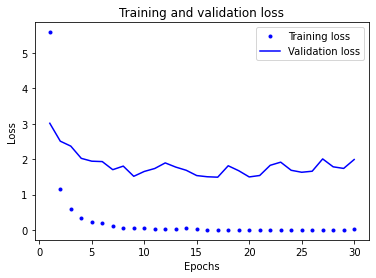

In [23]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b.", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

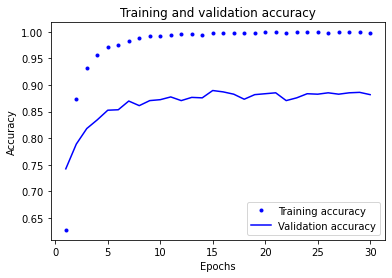

In [24]:
plt.clf()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, "b.", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
model = keras.models.load_model('model5/model')
results= model.evaluate(test_features, test_labels)
results

37/37 [==============================] - 0s 8ms/step - loss: 1.8339 - accuracy: 0.8897


[1.8338689804077148, 0.8896551728248596]

In [26]:
model = keras.models.load_model('model5/best_version')
results= model.evaluate(test_features, test_labels)
results

37/37 [==============================] - 0s 6ms/step - loss: 1.4920 - accuracy: 0.8940


[1.49197518825531, 0.8939655423164368]